In [11]:
include("DiscreteMaps.jl")
using Gadfly
using DiscreteMaps
M = DiscreteMaps.spdoubling(0.13)#logistic([3.8];newdom=true)
N = 21
NB = 1000


d1 = 0. #0.1805 + 10*eps(1.)
ds = 1. #0.95 - 10*eps(1.) - d1 
hgd = d1 + ds*[0:NB]/NB
pgd = d1 + ds*[0.5:NB-0.5]/NB;
(mu,S) = DiscreteMaps.spectralacim(M,N;verbose=true);
"Lyapunov exponent", DiscreteMaps.lyapunov(M,mu) |> println
#rhopgd = rho(pgd);

Doing linear algebra stuff
Smallest singular values are {0.0069759999999999996,0.28200000000000003,0.3301,0.5621,0.5834}
r: [1.0 0.5158 0.0 0.3249 0.0 0.2004 0.0 0.1252 0.0 0.1057]
Lr: [1.0079 0.5157 0.0 0.3251 0.0 0.2 0.0 0.1257 0.0 0.1049]
1.9869994271043012


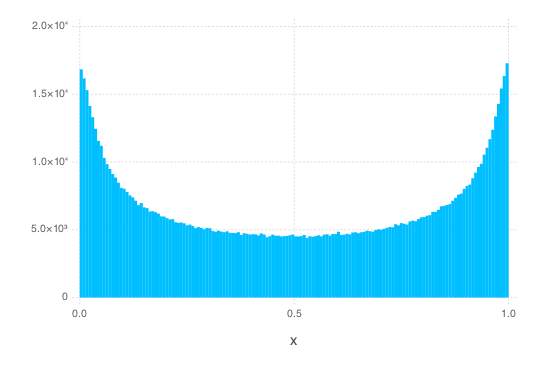

In [12]:
NI = 10^6
#xhlog = xh
xh = DiscreteMaps.iterate(M,NI)[:]
(nothing, xhcts) = hist(xh,hgd)
Gadfly.plot(x=xh,Geom.histogram)

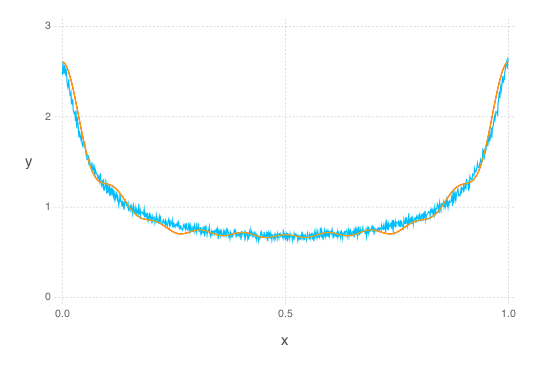

In [13]:
#DiscreteMaps.measureint(M.dom,Sp)[1] * r[1] +
#    diff(DiscreteMaps.chebyapprox(M.dom[:],DiscreteMaps.chebyint(N,M.dom)' * r[2:end],M.dom)) |> println
#mu = DiscreteMaps.SpectralMeasure([1.,0.,1.,0.,0.,0.,0.,0.,0.,0.,0.,1.,0.,1.],[0. 1.],false)
(rhospcd,rhospcde) = DiscreteMaps.measureint(hgd,mu)
(rhospcd2,rhospcde2) = DiscreteMaps.measureint(hgd,mu,x->1.)
#rhoccd = diff(DiscreteMaps.chebyapprox(hgd,DiscreteMaps.chebyint(N,M.dom)' * r[2:end],M.dom))
#rhocdf = r[1] * rhospcd + rhoccd

Gadfly.plot(
layer(x=pgd,y=rhospcd*NB/ds,Geom.line,Theme(default_color=color("orange"))),Scale.y_continuous(#maxvalue=2
),
layer(x=pgd,y=xhcts/NI*NB/ds,Geom.line),
layer(x=pgd,y=rhospcd2*NB/ds,Geom.line,Theme(default_color=color("red")))
)
#DiscreteMaps.chebyint(N)' * r[2:end]
#
#rhoi = quadgk(x->real(rho([x])[1]),0.05,sort(Sp.CO.pts[:])...) #quadgk(rho,hgd...)
#quadgk(x->real(rho([x])[1]),0.051,0.1805,0.181627)
#rho(0.181627)
#sort(Sp.CO.pts[:])


In [14]:
# Gadfly.plot(
# layer(x=pgd,y=xhcts,Geom.line,Theme(default_color=color("orange"))),Scale.y_continuous(maxvalue=10),
# layer(x=pgd,y=rhospcd*NB/0.9,Geom.line)
# )

Ns = [10:10:100,200]#,120:20:200]+1,250:50:500]#[21,22,31,32,41,42,51,52,76,77,101,102,151,152,201,202,301,302,401,402]
L = minimum(Ns)
NNs = length(Ns)
rv = Array(Float64,L,NNs)
tv = Array(Float64,NNs)
sv1v = Array(Float64,NNs)
sv2v = Array(Float64,NNs)
for i = 1:NNs
    tstart = tic()
    (mu, S) = DiscreteMaps.spectralacim(M,Ns[i];verbose=false)
    tv[i] = toc()
    sl = length(S) 
    sv1v[i] = S[sl]
    sv2v[i] = S[sl-1]
    rv[:,i] = mu.coeffs[1:L]
    (rhopgd,rhopgde) = DiscreteMaps.measureint(hgd,mu)   
    goodvals = (xhcts .> 0)
    NG = sum(goodvals)
    rhopgd *= NI
    "Chi-square value: ",Distributions.ccdf(Distributions.Chisq(NG-1),sum(((xhcts - rhopgd)[goodvals]).^2 ./ (rhopgd[goodvals]))) |> println
end

elapsed time: 0.004583188 seconds
0.0
elapsed time: 0.026517564 seconds
0.0
elapsed time: 0.055432598 seconds
1.4990427929196654e-12
elapsed time: 0.14973645 seconds
0.63917969865228
elapsed time: 0.127417724 seconds
0.9881503910011341
elapsed time: 0.364944281 seconds
0.9947969169739533
elapsed time: 0.380675801 seconds
0.9936674826451621
elapsed time: 0.566316126 seconds
0.9940666244105915
elapsed time: 0.655543616 seconds
0.9942417996094306
elapsed time: 0.949206612 seconds
0.9941768166987737
elapsed time: 3.606567402 seconds
0.9941656378870344


In [15]:
using Gadfly, Distributions
gcolor(str::String) = Theme(default_color=color(str));
function ddplot(p::Plot,pstr::String)
    Gadfly.display(p);
#    Gadfly.draw(PDF("/results/l-$(pstr).pdf",16cm,10cm),p);
    nothing
end;

function makelayer!(layerm::Vector{Layer},x::Vector,y::Vector,legstr::String,args...)
    thelayer = layer(
    x=x,y=y,
    color = fill(legstr,length(x)),
    args...
    )
    append!(layerm,thelayer)
    nothing
end;
#makelayer!(layerm::Vector{Layer},f::Function,legstr::String,args...) = makelayer!(layerm,plotgrid,f(plotgrid),legstr,args...);



layerm = Layer[]
    makelayer!(layerm,Ns,abs(rv[1,:] - rv[1,NNs])[:],"k̂",Geom.point)

for i = [2,3,4,6,9]
    makelayer!(layerm,Ns,abs(rv[i,:] - rv[i,NNs])[:],"r̂$(i-2)",Geom.point)
end
spdrp = plot(layerm,Scale.x_log2,Scale.y_log2,Guide.colorkey(""),Guide.xlabel("N"),Guide.ylabel("Error"))

ddplot(spdrp,"l-spderror.pdf")
exp(sqrt(var(log2(abs(rv[2,1:NNs-1] - rv[2,NNs])))/var(log((Ns[1:NNs-1])))) |> println
DiscreteMaps.lyapunov(M,mu)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 N 
 
 
 2 -3 
 2 -2 
 2 -1 
 2 0 
 2 1 
 2 2 
 2 3 
 2 4 
 2 5 
 2 6 
 2 7 
 2 8 
 2 9 
 2 10 
 2 11 
 2 12 
 2 13 
 2 14 
 2 -2.0 
 2 -1.8 
 2 -1.6 
 2 -1.4 
 2 -1.2 
 2 -1.0 
 2 -0.8 
 2 -0.6 
 2 -0.4 
 2 -0.2 
 2 0.0 
 2 0.2 
 2 0.4 
 2 0.6 
 2 0.8 
 2 1.0 
 2 1.2 
 2 1.4 
 2 1.6 
 2 1.8 
 2 2.0 
 2 2.2 
 2 2.4 
 2 2.6 
 2 2.8 
 2 3.0 
 2 3.2 
 2 3.4 
 2 3.6 
 2 3.8 
 2 4.0 
 2 4.2 
 2 4.4 
 2 4.6 
 2 4.8 
 2 5.0 
 2 5.2 
 2 5.4 
 2 5.6 
 2 5.8 
 2 6.0 
 2 6.2 
 2 6.4 
 2 6.6 
 2 6.8 
 2 7.0 
 2 7.2 
 2 7.4 
 2 7.6 
 2 7.8 
 2 8.0 
 2 8.2 
 2 8.4 
 2 8.6 
 2 8.8 
 2 9.0 
 2 9.2 
 2 9.4 
 2 9.6 
 2 9.8 
 2 10.0 
 2 10.2 
 2 10.4 
 2 10.6 
 2 10.8 
 2 11.0 
 2 11.2 
 2 11.4 
 2 11.6 
 2 11.8 
 2 12.0 
 2 12.2 
 2 12.4 
 2 12.6 
 2 12.8 
 2 13.0 
 2 -5 
 2 0 
 2 5 
 2 10 
 2 15 
 2 -2.0 
 2 -1.5 
 2 -1.0 
 2 -0.5 
 2 0.0 
 2 0.5 
 2 1.0 
 2 1.5 
 2 2.0 
 2 2.5 
 2 3.0 
 2 3.5 
 2 4.0 
 2 4.5 
 2 5.0 
 2 5.5 
 2 6.0 
 2 6.5 
 2 7.0 
 2 7.5 
 2 8.0 
 2 8.5 
 2 9.0 
 2 9.5 
 2 10.0 
 2 10.5 
 2 11.0 
 2 11.5 
 2 12.0 
 2 12.5 
 2 13.0 
 
 
 
 k̂ 
 r̂0 
 r̂1 
 r̂2 
 r̂4 
 r̂7 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2 -130 
 2 -120 
 2 -110 
 2 -100 
 2 -90 
 2 -80 
 2 -70 
 2 -60 
 2 -50 
 2 -40 
 2 -30 
 2 -20 
 2 -10 
 2 0 
 2 10 
 2 20 
 2 30 
 2 40 
 2 50 
 2 60 
 2 70 
 2 -120 
 2 -118 
 2 -116 
 2 -114 
 2 -112 
 2 -110 
 2 -108 
 2 -106 
 2 -104 
 2 -102 
 2 -100 
 2 -98 
 2 -96 
 2 -94 
 2 -92 
 2 -90 
 2 -88 
 2 -86 
 2 -84 
 2 -82 
 2 -80 
 2 -78 
 2 -76 
 2 -74 
 2 -72 
 2 -70 
 2 -68 
 2 -66 
 2 -64 
 2 -62 
 2 -60 
 2 -58 
 2 -56 
 2 -54 
 2 -52 
 2 -50 
 2 -48 
 2 -46 
 2 -44 
 2 -42 
 2 -40 
 2 -38 
 2 -36 
 2 -34 
 2 -32 
 2 -30 
 2 -28 
 2 -26 
 2 -24 
 2 -22 
 2 -20 
 2 -18 
 2 -16 
 2 -14 
 2 -12 
 2 -10 
 2 -8 
 2 -6 
 2 -4 
 2 -2 
 2 0 
 2 2 
 2 4 
 2 6 
 2 8 
 2 10 
 2 12 
 2 14 
 2 16 
 2 18 
 2 20 
 2 22 
 2 24 
 2 26 
 2 28 
 2 30 
 2 32 
 2 34 
 2 36 
 2 38 
 2 40 
 2 42 
 2 44 
 2 46 
 2 48 
 2 50 
 2 52 
 2 54 
 2 56 
 2 58 
 2 60 
 2 -200 
 2 -100 
 2 0 
 2 100 
 2 -120 
 2 -115 
 2 -110 
 2 -105 
 2 -100 
 2 -95 
 2 -90 
 2 -85 
 2 -80 
 2 -75 
 2 -70 
 2 -65 
 2 -60 
 2 -55 
 2 -50 
 2 -45 
 2 -40 
 2 -35 
 2 -30 
 2 -25 
 2 -20 
 2 -15 
 2 -10 
 2 -5 
 2 0 
 2 5 
 2 10 
 2 15 
 2 20 
 2 25 
 2 30 
 2 35 
 2 40 
 2 45 
 2 50 
 2 55 
 2 60 
 
 
 Error

LoadError: syntax: missing comma or ) in argument list
while loading In[15], in expression starting on line 32

In [16]:
i=20
Ns[i] |> println
tstart = tic()
    (mu, S) = DiscreteMaps.spectralacim(M,Ns[i];verbose=false)
    tv[i] = toq()
    sl = length(S) 
    sv1v[i] = S[sl]
    sv2v[i] = S[sl-1]
    rv[:,i] = r[1:L]
(rhopgd,nothing) = DiscreteMaps.measureint(hgd,mu)  
rhopgd *= NB / ds
    goodvals = (xhcts .> 0)
    NG = sum(goodvals)
Distributions.ccdf(Distributions.Chisq(NG-1),sum(((xhcts - rhopgd)[goodvals] * ds* NI / NB).^2 ./ (rhopgd[goodvals] * ds* NI / NB))) |> println

LoadError: BoundsError()
while loading In[16], in expression starting on line 2

In [17]:
plot(x=1:NG,y=((xhcts - rhopgd)[goodvals] * ds* NI / NB).^2 ./ (abs(rhopgd[goodvals]) * ds* NI / NB
),Geom.line)
#mean(xhcts)/mean(rhopgd)*ds/NB
Distributions.ccdf(Distributions.Chisq(NG-1),sum(((xhcts - rhopgd)[goodvals] * ds* NI / NB).^2 ./ (rhopgd[goodvals] * ds* NI / NB))) |> println

LoadError: NG not defined
while loading In[17], in expression starting on line 1

In [18]:
Gadfly.plot(
layer(x=pgd,y=xhcts,Geom.line,Theme(default_color=color("orange"))),Scale.y_continuous(maxvalue=10),
layer(x=pgd,y=rhopgd,Geom.line),
Scale.x_continuous(minvalue=0.9)
)

LoadError: rhopgd not defined
while loading In[18], in expression starting on line 1

In [431]:
mean(rhospcd),mean(xhcts)

(0.0010000267060213358,1.2995450682261285)